In [195]:
%pip install torch xgboost tensorflow keras

In [196]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score, classification_report, f1_score, accuracy_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.src.saving import load_model

pd.set_option('display.max_columns', None)

df = pd.read_csv('data.csv', on_bad_lines="warn", delimiter=";")
df.head()

,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Hovedområde start,Lokasjon start (kode),Havdybde start,Stopptidspunkt,Stoppdato,Stoppklokkeslett,Varighet,Fangstår,Stopposisjon bredde,Stopposisjon lengde,Hovedområde stopp (kode),Hovedområde stopp,Lokasjon stopp (kode),Havdybde stopp,Trekkavstand,Redskap FAO (kode),Redskap FAO,Redskap FDIR (kode),Redskap FDIR,Hovedart FAO (kode),Hovedart FAO,Hovedart - FDIR (kode),Art FAO (kode),Art FAO,Art - FDIR (kode),Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",NaN,NaN,NaN,-2740,01.01.2018,01.01.2018,00:00,1440,2018,"-60,4","-46,15",NaN,NaN,NaN,-805,5649.0,OTM,"Flytetrål, otter",53.0,Flytetrål,KRI,Antarktisk krill,2513.0,KRI,Antarktisk krill,2513.0,Antarktisk krill,506.0,Antarktisk krill,706714.0,5.0,28 m og over,9432.0,NaN,"19,87","133,88"
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,HAD,Hyse,1027.0,Hyse,202.0,Hyse,9594.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,COD,Torsk,1022.0,Torsk,201.0,Torsk,8510.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,GHL,Blåkveite,2313.0,Blåkveite,301.0,Blåkveite,196.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,POK,Sei,1032.0,Sei,203.0,Sei,134.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"


As our hypothetical use case, we imagine a government agency that is interested to predict how much endangered fish a given catch operation has caught.

We used "https://artsdatabanken.no/lister/rodlisteforarter/2021?Name=&SortBy=ScientificName&Meta=Visited&Meta=scroll_658&IsCheck=Area&Area=N&IsCheck=Category&Category=CR&Category=EN&IsCheck=SpeciesGroups&SpeciesGroups=Fisker&IsCheck=Insekter" to find endangered species of fish. 

Three of these are included in the dataset:

1. Vanlig Uer
2. Blålange
3. Ål

Our strategy will be to trim unnecessary columns, turn species into boolean columns and have machine learning models predict the amount (weight) caught of the given species for each catch operation.

<!-- A lot of the data in the columns needs to be converted into boolean and number values, and some needs to be omitted due to inaccuracies.  -->



In [197]:
# df.info()
uer_df = df[df['Art FAO'] == "Uer (vanlig)"] 
blålange_df = df[df['Art FAO'] == "Blålange"] 
ål_df = df[df['Art FAO'] == "Ål"] 
print("Number of catches containing Uer: ", len(uer_df))
print("Number of catches containing Blålange: ", len(blålange_df))
print("Number of catches containing Ål: ", len(ål_df))


Number of catches containing Uer:  14153
Number of catches containing Blålange:  991
Number of catches containing Ål:  2


There are only two catch operations containing Ål, we need more data in order to predict for this species.
For Blålange and Uer we can move on. It's difficult to say beforehand wether or not 991 positive datapoints will be enough to accurately predict the Rundvekt of Blålange, but it's within the realm of possibilities.
 
**Data Processing**

To begin trimming down the amount of data, we can safely drop columns where the data is already present in other columns

In [198]:
df = df.drop(labels=["Meldingsdato","Meldingsklokkeslett","Startdato","Startklokkeslett", "Stoppdato", "Stoppklokkeslett", "Lengdegruppe (kode)", "Lengdegruppe"], axis=1)
df = df.drop(labels=["Hovedart FAO (kode)","Hovedart FAO","Hovedart - FDIR (kode)","Art - gruppe","Art - gruppe (kode)", "Art - FDIR (kode)", "Art - FDIR", "Redskap FDIR (kode)", "Redskap FDIR"], axis=1)



We notice that Start/Stop times are inconsistent. We therefore filter out Start/Stop times which do not contain ':'. This way we can trust the 'Varighet' column more.

Furthermore, 'Fartøylengde', 'Bredde', 'Startposisjon bredde', 'Startposisjon lengde', 'Stopposisjon bredde', 'Stopposisjon lengde' is written with ',' and not '.'. We change ',' to '.' and cast to float datatype.

In [199]:
df = df[df["Starttidspunkt"].str.contains(":")]
df = df[df["Stopptidspunkt"].str.contains(":")]

castable_columns = ["Fartøylengde", "Bredde", "Startposisjon bredde", "Startposisjon lengde", "Stopposisjon bredde", "Stopposisjon lengde"]

for column in castable_columns:
    df[column] = df[column].str.replace(",", ".").astype("float")



Next we need to convert the categorical column values we _do_ want to use into machine-readable data. In this case we use the built-in get_dummies function to create boolean columns.

In [200]:
species_columns = pd.get_dummies(df["Art FAO"], dtype="float") 
species_columns_multiplied = species_columns.multiply(df["Rundvekt"], axis="index") # Keep weight of fish

endangered_species_1 = species_columns_multiplied["Uer (vanlig)"]
endangered_species_2 = species_columns_multiplied["Blålange"]

# Add endangered species and drop original columns.
df = pd.concat([df,endangered_species_1 ], axis=1)
df = pd.concat([df,endangered_species_2 ], axis=1)
df = df.drop(["Art FAO", "Art FAO (kode)" ], axis=1)

tool_columns = pd.get_dummies(df["Redskap FAO"])
df = pd.concat([df,tool_columns], axis=1) 

df = df.drop(["Redskap FAO", "Redskap FAO (kode)"], axis=1)


In order to reduce the amount of parameters, we group the fishing tools into sensible categories.

In [201]:
groups_to_combine = {
    'DivBunntrål': ['Bunntrål (uspes)', 'Bunntrål, otter', 'Bunntrål, par', 'Bunntrål, reke', 'Skrape, mekanisert', 'Otter dobbeltrål'],
    'DivSnurrevad': ['Snurrevad, skotsk', 'Snurrevad, dansk', 'Snurrevad'],
    'DivSnurpenot/ringnot': ['Snurpenot/ringnot, to fartøy', 'Snurpenot/ringnot, et fartøy', 'Snurpenot/ringnot', 'Boat /vessel seines -Pair seines'],
    'DivFlytetrål': ['Flytetrål, otter', 'Flytetrål, par', 'Flytetrål, reke', 'Flytetrål, uspesifisert'],
    'DivGarn': ['Udefinert garn', 'Settegarn', 'Gillnets and entangling nets (unspec)*', 'Encircling gillnets*'],
    'DivLine': ['Andre liner', 'Setteline', 'Dorg/harp/snik', 'Juksa/pilk, manuell'],
    'Annet': ['Harpun,div.', 'Partrål, uspesifisert', 'Teiner', 'Udefinert trål', 'Annen trål (udefinert)']
}

for new_column, columns_to_group in groups_to_combine.items():
    df[new_column] = df[columns_to_group].any(axis=1)
    df.drop(columns=columns_to_group, inplace=True)

df.head()

,Melding ID,Meldingstidspunkt,Starttidspunkt,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Hovedområde start,Lokasjon start (kode),Havdybde start,Stopptidspunkt,Varighet,Fangstår,Stopposisjon bredde,Stopposisjon lengde,Hovedområde stopp (kode),Hovedområde stopp,Lokasjon stopp (kode),Havdybde stopp,Trekkavstand,Rundvekt,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde,Uer (vanlig),Blålange,DivBunntrål,DivSnurrevad,DivSnurpenot/ringnot,DivFlytetrål,DivGarn,DivLine,Annet
1,1497178,01.01.2018,30.12.2017 23:21,74.885,16.048,20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,295,2017,74.914,15.969,20.0,Bjørnøya,7.0,-334,3970.0,9594.0,1476.0,NaN,12.6,56.8,0.0,0.0,True,False,False,False,False,False,False
2,1497178,01.01.2018,30.12.2017 23:21,74.885,16.048,20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,295,2017,74.914,15.969,20.0,Bjørnøya,7.0,-334,3970.0,8510.0,1476.0,NaN,12.6,56.8,0.0,0.0,True,False,False,False,False,False,False
3,1497178,01.01.2018,30.12.2017 23:21,74.885,16.048,20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,295,2017,74.914,15.969,20.0,Bjørnøya,7.0,-334,3970.0,196.0,1476.0,NaN,12.6,56.8,0.0,0.0,True,False,False,False,False,False,False
4,1497178,01.01.2018,30.12.2017 23:21,74.885,16.048,20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,295,2017,74.914,15.969,20.0,Bjørnøya,7.0,-334,3970.0,134.0,1476.0,NaN,12.6,56.8,0.0,0.0,True,False,False,False,False,False,False
5,1497178,01.01.2018,31.12.2017 05:48,74.910,15.868,20.0,Bjørnøya,7.0,-403,31.12.2017 10:15,267,2017,74.901,16.248,20.0,Bjørnøya,7.0,-277,11096.0,9118.0,1476.0,NaN,12.6,56.8,0.0,0.0,True,False,False,False,False,False,False


When grouping the different catch operations, it's important to be precise when telling pandas how to process the different rows.

The data in most columns is identical, for those we can use 'mean' or 'first'.

For some, like the endangered species columns, only one row will contain our fish, rest will be zero. We must therefore use 'sum' to capture the weight of the endangereed species.

For 'Rundvekt' we should also use 'sum'. 

In [202]:
species_dict = {
    "Uer (vanlig)": "sum",
    "Blålange": "sum",
}
tool_dict= dict.fromkeys(['Annet','DivBunntrål','DivSnurrevad','DivSnurpenot/ringnot','DivFlytetrål','DivGarn','DivLine'], "first")

catch_dict = {
        "Varighet": "mean",
        "Fangstår": "mean",
        "Trekkavstand": "mean",
        "Bredde": "mean",
        "Fartøylengde" : "mean",
        "Bruttotonnasje": "mean",
        "Rundvekt": "sum",
        "Havdybde start": "mean",
        "Havdybde stopp": "mean",
        "Startposisjon lengde": "mean",
        "Startposisjon bredde": "mean",
        "Stopposisjon lengde": "mean",
        "Stopposisjon bredde": "mean",

    }
master_dict = {**catch_dict, **tool_dict, **species_dict}

It's natural to think that the size of the vessel is important for predicting how much fish is caught.

In order to use 'Bruttotonnasje' one option is to pick one of the columns, delete the other one and drop all n/a values.

We decided on a slightly different approach in order to preserve more rows.
We base the 'Bruttotonnasje' value on the standard 'Bruttotonnasje 1969' and instead of dropping rows right away, we check if the row contains a value in 'Bruttotonnasje annen', and use that.
Rows with missing values in both columns are dropped.


In [203]:

df = df.dropna(subset=["Bruttotonnasje 1969", "Bruttotonnasje annen"], how='all')
df["Bruttotonnasje"] = df["Bruttotonnasje 1969"].fillna(df["Bruttotonnasje annen"])
df = df.drop(["Bruttotonnasje 1969", "Bruttotonnasje annen"], axis=1)


It should be noted that 'Bruttotonnasje' is pretty well explained by 'Fartøylengde', although in a non-linear fashion. In light of this, we could probably omit either 'Bruttotonnasje' or the boat dimensions.
See graph.

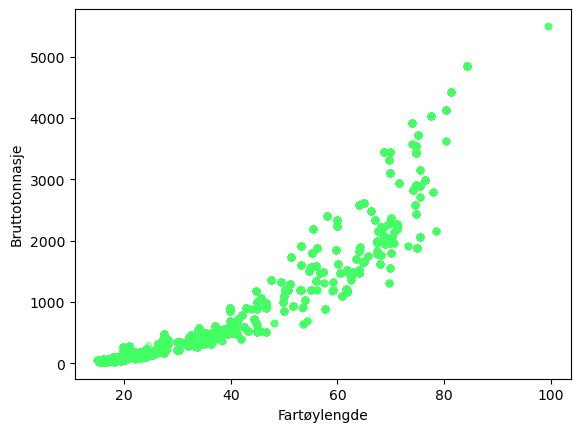

In [204]:

df.plot(kind = 'scatter', x = 'Fartøylengde', y = 'Bruttotonnasje', c="#43ff640d")
plt.show()

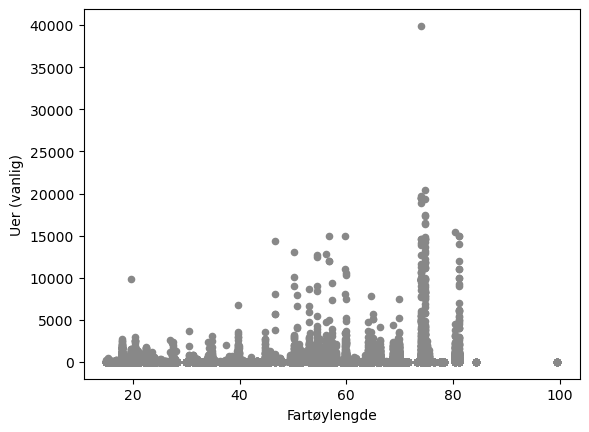

In [205]:

df.plot(kind = 'scatter', x = 'Fartøylengde', y = 'Uer (vanlig)', c="#888")
plt.show()

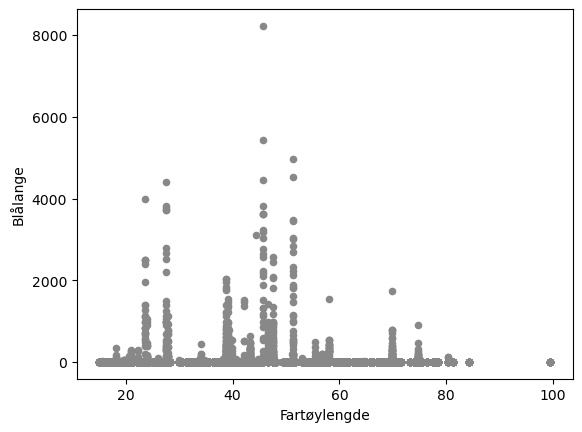

In [206]:

df.plot(kind = 'scatter', x = 'Fartøylengde', y = 'Blålange', c="#888")
plt.show()

Some catch operations are claimed to have taken place in very unusual and sometimes impossible locations.
Furthermore, some weights of the endangered species are incredibly high. We suspect this will distort the model, so we remove those.

In [207]:
df = df.drop(df[df["Startposisjon lengde"] < -50].index)
df = df.drop(df[df["Startposisjon lengde"] > 60].index)
df = df.drop(df[df["Startposisjon bredde"] < 40].index)
df = df.drop(df[df["Uer (vanlig)"] > 25000].index) # Outlier
df = df.drop(df[df["Blålange"] > 8000].index) # Outlier


Geographic Visualization of where Uer is caught surrounding Norway. 

C:\Users\Thoma\AppData\Local\Temp\ipykernel_34264\3084032132.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.datasets.get_path("naturalearth_lowres"))


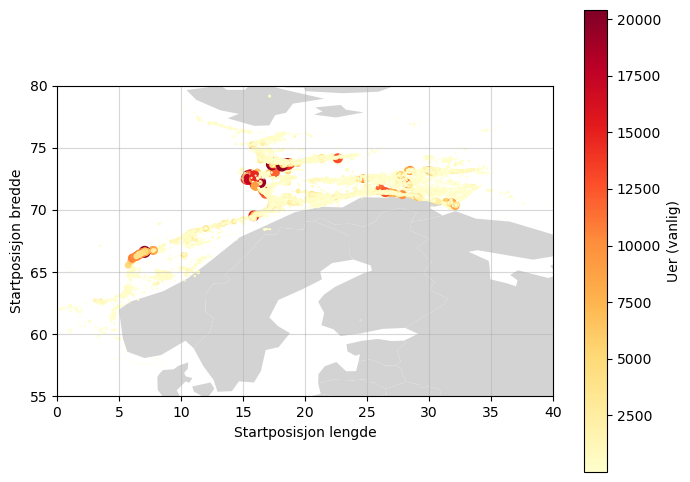

In [208]:
# initialize an axis
fig, ax = plt.subplots(figsize=(8,6))
# plot map on axis
countries = gpd.read_file(  
     gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey",
                                                 ax=ax)
df_positive_uer = df.drop(df[df["Uer (vanlig)"] == 0].index)

# plot points
df_positive_uer.plot(x="Startposisjon lengde", y="Startposisjon bredde", kind="scatter", 
        c="Uer (vanlig)", colormap="YlOrRd", s=df_positive_uer["Uer (vanlig)"].multiply(0.003),
        ax=ax)
# add grid
ax.grid( alpha=0.5)
ax.set_xlim(0, 40)
ax.set_ylim(55, 80)
plt.show()


Geographic Visualization of where Blålange is caught surrounding Norway. 

C:\Users\Thoma\AppData\Local\Temp\ipykernel_34264\1963709436.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.datasets.get_path("naturalearth_lowres"))


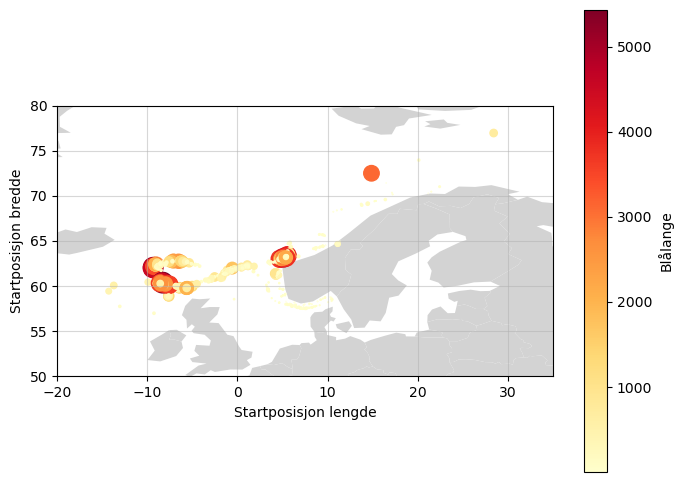

In [209]:
# initialize an axis
fig, ax = plt.subplots(figsize=(8,6))
# plot map on axis
countries = gpd.read_file(  
     gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey",
                                                 ax=ax)

df_positive_lange = df.drop(df[df["Blålange"] == 0].index)
# plot points
df_positive_lange.plot(x="Startposisjon lengde", y="Startposisjon bredde", kind="scatter", 
        c="Blålange", colormap="YlOrRd", s=df_positive_lange["Blålange"].multiply(0.04),
        ax=ax)
# add grid
ax.grid( alpha=0.5)
ax.set_xlim(-20, 35)
ax.set_ylim(50, 80)
plt.show()

We are now ready to collapse the entries into catch operations.

In [210]:

df_processed = df.groupby(by=["Melding ID", "Starttidspunkt", "Stopptidspunkt"]).agg(master_dict).reset_index()
df_processed =  df_processed.drop(columns=['Starttidspunkt','Stopptidspunkt',"Melding ID"])
df_processed = df_processed.dropna()
df_processed


,Varighet,Fangstår,Trekkavstand,Bredde,Fartøylengde,Bruttotonnasje,Rundvekt,Havdybde start,Havdybde stopp,Startposisjon lengde,Startposisjon bredde,Stopposisjon lengde,Stopposisjon bredde,Annet,DivBunntrål,DivSnurrevad,DivSnurpenot/ringnot,DivFlytetrål,DivGarn,DivLine,Uer (vanlig),Blålange
0,295.0,2017.0,3970.0,12.60,56.80,1476.0,18434.0,-335.0,-334.0,16.048,74.885,15.969,74.914,False,True,False,False,False,False,False,0.0,0.0
1,267.0,2017.0,11096.0,12.60,56.80,1476.0,16062.0,-403.0,-277.0,15.868,74.910,16.248,74.901,False,True,False,False,False,False,False,0.0,0.0
2,315.0,2017.0,10215.0,12.60,56.80,1476.0,17878.0,-346.0,-496.0,16.056,74.883,15.742,74.924,False,True,False,False,False,False,False,37.0,0.0
3,243.0,2017.0,3214.0,12.60,56.80,1476.0,13780.0,-443.0,-358.0,15.785,74.931,15.894,74.926,False,True,False,False,False,False,False,0.0,0.0
4,63.0,2018.0,1269.0,5.06,19.10,51.0,4.0,-71.0,-56.0,12.972,67.828,12.942,67.827,False,False,True,False,False,False,False,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97718,232.0,2018.0,2400.0,10.50,39.79,691.0,9023.0,-191.0,-178.0,22.141,70.862,22.188,70.877,False,True,False,False,False,False,False,0.0,0.0
97719,301.0,2018.0,13284.0,12.60,57.30,1483.0,11105.0,-193.0,-341.0,14.295,76.509,14.679,76.431,False,True,False,False,False,False,False,51.0,0.0
97720,345.0,2018.0,44035.0,12.60,57.30,1483.0,10017.0,-244.0,-299.0,14.932,76.385,13.642,76.640,False,True,False,False,False,False,False,51.0,0.0
97721,328.0,2018.0,41216.0,12.60,57.30,1483.0,10427.0,-280.0,-289.0,13.800,76.606,12.820,76.899,False,True,False,False,False,False,False,102.0,0.0



***KNN Regressor model***


A k-nearest neighbors (KNN) regressor is a non-parametric machine learning model used for regression tasks. It predicts the value of a target variable by averaging the values of the k-nearest neighbors in the feature space.

Because of few observations of Blålange we focus on predicting Uer (vanlig).


In [211]:
df_knn = df_processed.copy()
X = df_knn.drop('Uer (vanlig)', axis=1)
y = df_knn['Uer (vanlig)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

The code under performs a grid search to optimize the hyperparameters of a KNN regressor model using 5-fold cross-validation. It searches through a predefined set of possible values for the number of neighbors ("n_neighbors") and the weighting function ("weights") to find the combination that minimizes the negative mean squared error. This approach is used to systematically work through multiple combinations of parameter tunes, cross-validating as it goes to determine which tune gives the best performance.

In [212]:

def getBestRegressor():
    # Defining parameter grid
    param_grid = {'n_neighbors': [3, 4, 5, 6, 7, 10, 15, 20], 'weights': ['uniform', 'distance']}
    grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)
    # finding the best parameters
    print("Best parameters:", grid_search.best_params_)
    best_knn_regressor = grid_search.best_estimator_
    return best_knn_regressor


In [213]:

# knn_regressor = getBestRegressor() # Function takes very long time to run.
knn_regressor = KNeighborsRegressor(n_neighbors=3, weights="distance")
knn_regressor.fit(X_train_scaled, y_train)
y_pred = knn_regressor.predict(X_test_scaled)

In [214]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2 Score: {r2}")

MSE: 118537.19460084912
RMSE: 344.2923098195037
MAE: 48.441874183736765
R^2 Score: 0.5369314064181838


MSE: Mean Squared Error is a measure of the average squared difference between the observed actual amount of Uer (vanlig) and the  predicted amount of Uer (vanlig) by the model, indicating a value of 122,397.15 in this case.

RMSE: Root Mean Squared Error is the square root of MSE, providing a measure of the average magnitude of the errors, with a value of 349.85 suggesting the typical prediction error's size.

MAE: Mean Absolute Error (MAE) is the average of the absolute differences between predicted values of Uer (vanlig) and actual values, with a value of 49.21 indicating the average prediction error in the same units as the data.

R^2 Score: The R-squared score, often called the coefficient of determination, is the proportion of the variance in the dependent variable that is predictable from the independent variables, with a value of 0.52 indicating that approximately 52.19% of the variability in the outcome is explained by the model.

We now want to visualize the predictions made by our model.


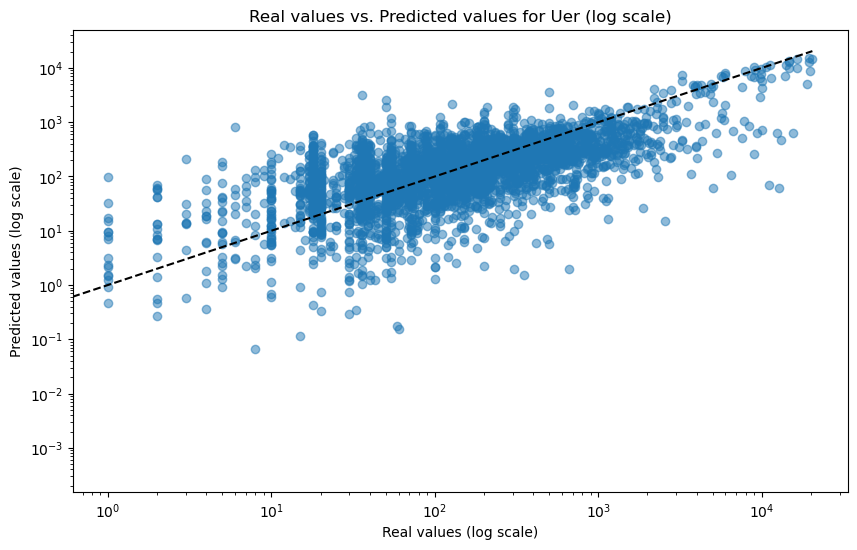

In [233]:
def plotPredictions(test,pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(test, pred, alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Real values (log scale)')
    plt.ylabel('Predicted values (log scale)')
    plt.title('Real values vs. Predicted values for Uer (log scale)')

    plt.plot([min(test), max(test)], [min(test), max(test)], 'k--')
    plt.show()

plotPredictions(y_test, y_pred)

The log graph indicates that the model is capable of predicting the correct values to a certain extent, as evidenced by the clustering of data points along the line of perfect prediction, although there is still some deviation present.

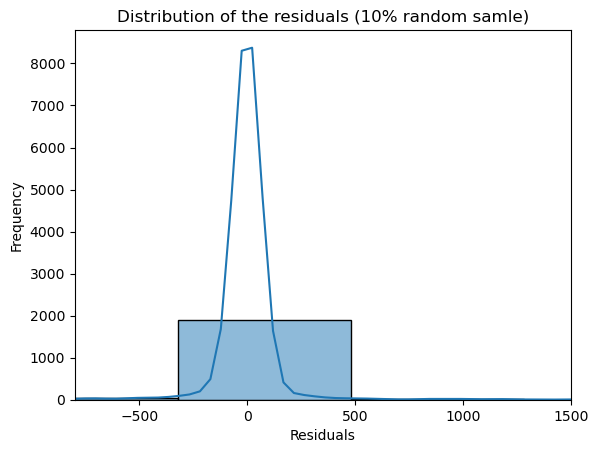

In [216]:
residuals = y_test - y_pred
residuals = residuals[~np.isnan(residuals)]
residuals = residuals[np.isfinite(residuals)]

# Distribution of 10% random sample of the data resudials
test_size = int(len(residuals) * 0.1)
random_sample = np.random.choice(residuals, size=test_size, replace=False)

plt.xlim(-800, 1500)
sns.histplot(random_sample, kde=True)
plt.title('Distribution of the residuals (10% random samle)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

The residuals being centered around zero suggests that the model's predictions are, on average, accurate, as there is no systematic overprediction or underprediction. This indicates a good fit between the model and the observed data.

***Tensorflow deep learning model***

A TensorFlow deep learning model is a computational architecture composed of multiple layers of interconnected nodes, or "neurons," designed to recognize patterns in data by adjusting internal parameters through a process known as training. TensorFlow is an open-source machine learning library developed by Google that facilitates the creation, training, and deployment of such models for a wide variety of complex tasks, including image and speech recognition, natural language processing, and more.


In [218]:

df_dl = df_processed.copy()

# Anta at 'Uer (vanlig)' er din kontinuerlige variabel
# Bestem terskler for kategoriene "ingen", "middels" og "høy"
# For eksempel, anta at du velger følgende terskler (disse bør tilpasses basert på dine data)
min_verdi = df_dl['Uer (vanlig)'].min()
max_verdi = df_dl['Uer (vanlig)'].max()
terskler = [min_verdi, 5, 10, max_verdi]

# Bruk 'pd.cut' for å opprette de kategoriske klassene
kategorier = ['ingen', 'middels', 'høy']
df_dl['Uer_kategorisert'] = pd.cut(df_dl['Uer (vanlig)'], bins=terskler, labels=kategorier, include_lowest=True)

# Oppdater 'y' til å bruke de nye kategoriske klassene
y = df_dl['Uer_kategorisert']

# Konverter kategorier til numeriske verdier for modellen
y = y.astype('category').cat.codes

# Del dataene inn i trenings- og testsett
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Bygg modellen med det nye antallet klasser (3 klasser)
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Juster input_shape etter antall funksjoner i X
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 klasser for "ingen", "middels", "høy"
])

# Kompiler modellen
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Tren modellen
model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_test, y_test)
)


c:\Users\Thoma\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7823 - loss: 279.3929 - val_accuracy: 0.8642 - val_loss: 0.4419
Epoch 2/10
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8595 - loss: 1.2254 - val_accuracy: 0.8642 - val_loss: 0.4159
Epoch 3/10
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8609 - loss: 4.5954 - val_accuracy: 0.8642 - val_loss: 0.4120
Epoch 4/10
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8611 - loss: 0.4959 - val_accuracy: 0.8642 - val_loss: 0.4087
Epoch 5/10
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8596 - loss: 0.4539 - val_accuracy: 0.8642 - val_loss: 0.4071
Epoch 6/10
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8583 - loss: 0.4293 - val_accuracy: 0.8642 - val_loss: 0.4070
Epoch 7/10
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8601 - loss: 0.4256 - val_accuracy: 0.8642 - val_loss: 0.4048
Epoch 8/10
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8590 - loss: 0.4444 

In [219]:

# Generer prediksjoner på testsettet
y_pred = model.predict(X_test)
# For softmax-utgangen vil du ha den klassen med høyest sannsynlighet
y_pred_classes = np.argmax(y_pred, axis=1)

# Beregn forvirringsmatrisen
conf_mat = confusion_matrix(y_test, y_pred_classes)
print("Forvirringsmatrise: \n")
print(conf_mat)

# Beregn klassifiseringsrapporten
class_report = classification_report(y_test, y_pred_classes, target_names=['ingen', 'middels', 'høy'])
print("\n Klassifiseringsrapport: \n")
print(class_report)

 46/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Forvirringsmatrise: 

[[25332     0     0]
 [   98     0     0]
 [ 3883     0     0]]

 Klassifiseringsrapport: 

              precision    recall  f1-score   support

       ingen       0.86      1.00      0.93     25332
     middels       0.00      0.00      0.00        98
         høy       0.00      0.00      0.00      3883

    accuracy                           0.86     29313
   macro avg       0.29      0.33      0.31     29313
weighted avg       0.75      0.86      0.80     29313



c:\Users\Thoma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thoma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thoma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***XGBoost Algo***


XGBoost, short for eXtreme Gradient Boosting, is an ensemble machine learning algorithm known for its efficiency and scalability in training models. It enhances accuracy by combining the predictions of several simpler models into a powerful composite predictor. 

The algorithm has a track record of winning numerous machine learning contests, making it not only a sound choice for the project but also a trendy one. One of XGBoost's key features is its efficient handling of missing data, which allows it to manage real-world datasets with missing values without great preprocessing. 

Incorporating XGBoost as one of our supervised learning models aligns with the precision required for our hypothetical use case and adds a touch of trendiness and spiciness to the project.


In [220]:
df_xgboost = df_processed.copy()
df_xgboost.drop("Blålange", axis = 1)

# Defining the independent variables (X) and the dependent varaible (y).
X = df_xgboost.drop('Uer (vanlig)', axis=1)
y = df_xgboost['Uer (vanlig)']

# Splitting the dataset into training and test set with a 70-30 split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



Model Tuning and Hyperparamterer Optimalization with Grid Search:

After splitting the dataset, it is important to perform fine-tuning on our model's hyperparameters. Tuning can ensure that we enhance the model's performance. We use Grid Search for this purpose, which methodically explores a range of possibilities for hyperparameters to find the best combinations. This process is computationally demanding, but it is crucial to avoid overlooking more optimized settings for our task.

In [221]:
"""from sklearn.model_selection import GridSearchCV

# Defining a reasonable paramterer grid or distribution to sample from.
param_grid = {
    'colsample_bytree': [0.3, 0.5, 0.7],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'alpha': [1, 10, 50],
    'n_estimators': [200, 250, 300]
}

# Initialize the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize GridSearchCV with the parameter grid, the XGBoost regressor, and cross-validation strategy
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print(f"Best parameters found: {grid_search.best_params_}")"""

'from sklearn.model_selection import GridSearchCV\n\n# Defining a reasonable paramterer grid or distribution to sample from.\nparam_grid = {\n    \'colsample_bytree\': [0.3, 0.5, 0.7],\n    \'learning_rate\': [0.01, 0.1, 0.2],\n    \'max_depth\': [3, 5, 7],\n    \'alpha\': [1, 10, 50],\n    \'n_estimators\': [200, 250, 300]\n}\n\n# Initialize the XGBoost regressor\nxg_reg = xgb.XGBRegressor(objective=\'reg:squarederror\')\n\n# Initialize GridSearchCV with the parameter grid, the XGBoost regressor, and cross-validation strategy\ngrid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, scoring=\'neg_mean_squared_error\', verbose=1)\n\n# Fit the GridSearchCV to the training data\ngrid_search.fit(X_train, y_train)\n\n# Print the best parameters found by GridSearchCV\nprint(f"Best parameters found: {grid_search.best_params_}")'

Result of Grid Search

The Grid search is a computationally demandning process and it can be time-consuming.
On my computer, the search took about 15 minutes. Therefore, I have included the results here.
The optimal hyperparamters identified by Grid Search for our XGBoost model are as follows:

alpha: 10

colsample_bytree: 0.5

learning_rate: 0.1

max_depth: 7

n_estimators: 200



In [222]:
# Initializing the the XGBoost regressor with hyperparamters.
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                        colsample_bytree = 0.7, 
                        learning_rate = 0.1,
                        max_depth = 7, 
                        alpha = 10, 
                        n_estimators =800)


xg_reg.fit(X_train, y_train)

y_pred = xg_reg.predict(X_test)

# Evaluering av modellen

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE (Mean Squared Error): {mse}")
print(f"RMSE (Root Mean Squared Error): {rmse}")
print(f"MAE (Mean Absolute Error): {mae}")
print(f"R^2 Score: {r2}")


MSE (Mean Squared Error): 101548.67455916264
RMSE (Root Mean Squared Error): 318.66702772512036
MAE (Mean Absolute Error): 56.34943470407068
R^2 Score: 0.6195464818190786


Feature Analysis

Before we examine the model's predictions in detail, it is important to understand the influence of different features on the model's output. Feature analysis helps us identify which features significantly impact the predictions and provides insights into the relationships within our data.



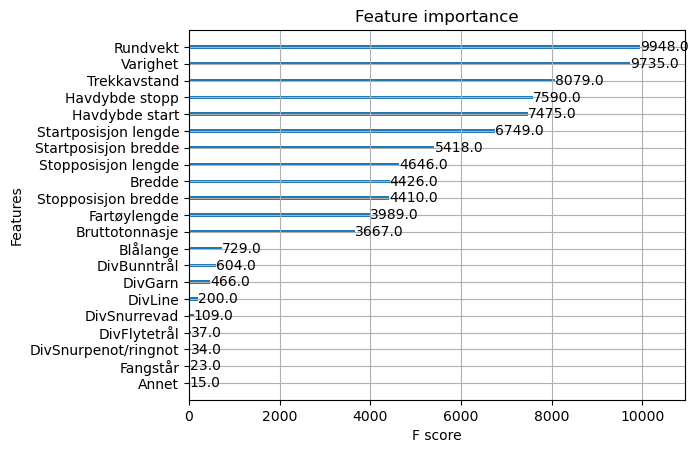

In [223]:
xgb.plot_importance(xg_reg)
plt.show()

Visualizing the Predictions

After examining the importance of different features, we will now provide a visualization of the model's predictions. By plotting actual values against predicted values, we can visualize the model's accuracy. The plot helps us visualize how closely the model's predictions align with the ideal representation of perfect agreement between predicted and actual values.


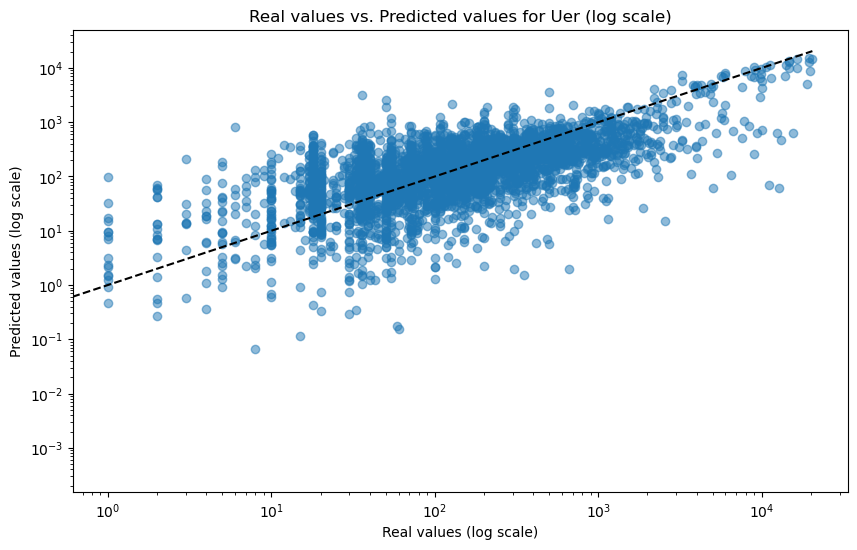

In [234]:

plotPredictions(y_test, y_pred)


Residual Analysis

Residual analysis is used in evaluation a regression models performance. The analysis examines the difference between actual and predicted values. Randomly distributed residuals tend to suggest a well-fitting model. 



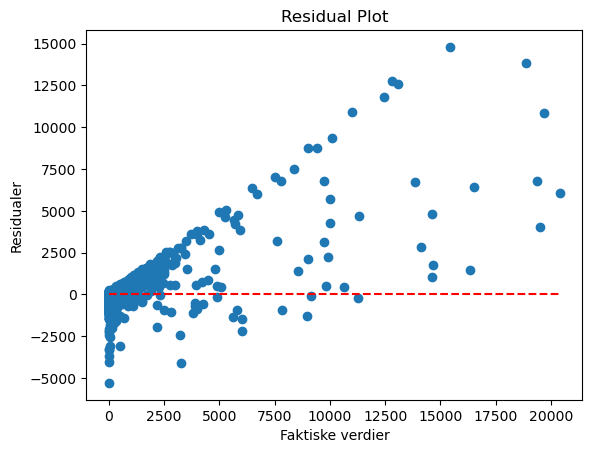

In [225]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max(), colors='r', linestyles='--')
plt.xlabel('Faktiske verdier')
plt.ylabel('Residualer')
plt.title('Residual Plot')
plt.show()








K-Means Clustering is an unsupervised machine learning algorithm used to identify and group similar data points into clusters. The algorithm partitions the data points into K distinct clusters, aiming to minimize the variance within each cluster and maximize the variance between clusters. We use K-Means to detect patterns that might be hidden within our data, without the need to predefine labels.





In [226]:
relevant_columns = ["Startposisjon bredde", "Startposisjon lengde", 
    "Havdybde start", "Varighet", "Fangstår", 
    "Stopposisjon bredde", "Stopposisjon lengde", 
    "Havdybde stopp", "Trekkavstand", "Rundvekt", 
    "Bredde", "Fartøylengde", "Bruttotonnasje"]

df_clustering = df_processed
df_clustering = df_clustering.dropna()

df_clustering = df_clustering[relevant_columns]

scaler = StandardScaler()
df_clustering_scaled = scaler.fit_transform(df_clustering)


In [227]:
df_clustering.head()

,Startposisjon bredde,Startposisjon lengde,Havdybde start,Varighet,Fangstår,Stopposisjon bredde,Stopposisjon lengde,Havdybde stopp,Trekkavstand,Rundvekt,Bredde,Fartøylengde,Bruttotonnasje
0,74.885,16.048,-335.0,295.0,2017.0,74.914,15.969,-334.0,3970.0,18434.0,12.60,56.8,1476.0
1,74.910,15.868,-403.0,267.0,2017.0,74.901,16.248,-277.0,11096.0,16062.0,12.60,56.8,1476.0
2,74.883,16.056,-346.0,315.0,2017.0,74.924,15.742,-496.0,10215.0,17878.0,12.60,56.8,1476.0
3,74.931,15.785,-443.0,243.0,2017.0,74.926,15.894,-358.0,3214.0,13780.0,12.60,56.8,1476.0
4,67.828,12.972,-71.0,63.0,2018.0,67.827,12.942,-56.0,1269.0,4.0,5.06,19.1,51.0


The Elbow Method:

To effectively utilize K-Means clustering, it is important to first determine an appropriate number of clusters. We have chosen the Elbow Method to find this number by calculating the inertia for different values of K.

Inertia measures the sum of squared distances of samples to their nearest cluster center. By plotting inertia values for different values of K, we can identify what is known as the "Elbow Point". At this point, the rate of decrease in the graph sharply changes.

This point suggests a balance between the number of clusters and the compactness of the clusters, which in turn indicates a suitable value for K in K-Means.

c:\Users\Thoma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c:\Users\Thoma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Thoma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Thoma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Thoma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

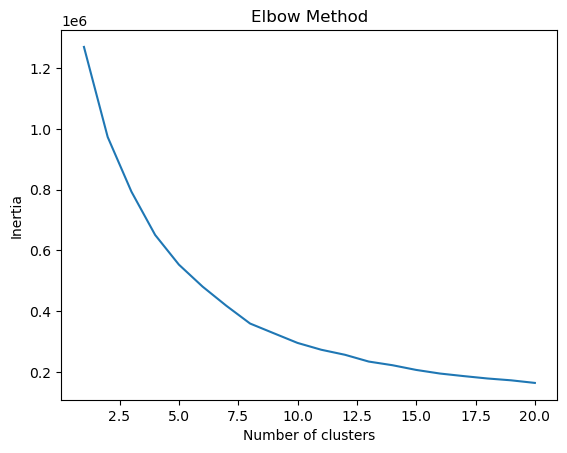

In [228]:
# For å velge antall k-clusters ved hjelp av elbow-metoden. 
inertia = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42) 
    kmeans.fit(df_clustering_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 21), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

After using plotting the graph, we find that a suitable value for K in K-means is K = 6.

In [229]:
k = 6

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(df_clustering_scaled)

labels = kmeans.labels_

df_processed_dropna = df_processed.dropna().copy()
df_processed_dropna["cluster"] = labels

for i in range(k):
    cluster_data = df_processed_dropna[df_processed_dropna["cluster"] == i]
    print(f"Cluster {i}:")
    # Sørg for at kolonnene 'Uer (vanlig)' og 'Blålange' eksisterer i df_processed før du prøver å få tilgang til dem
    if 'Uer (vanlig)' in df_processed_dropna.columns and 'Blålange' in df_processed_dropna.columns:
        print(f"Vanlig Uer: {cluster_data['Uer (vanlig)'].mean()}")
        print(f"Blålange: {cluster_data['Blålange'].mean()}")
    else:
        print("En eller begge kolonnene 'Uer (vanlig)' og 'Blålange' finnes ikke i DataFrame.")

c:\Users\Thoma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0:
Vanlig Uer: 6.776144366197183
Blålange: 8.476452464788732
Cluster 1:
Vanlig Uer: 26.4711676095699
Blålange: 0.11836275645831913
Cluster 2:
Vanlig Uer: 121.96906657631713
Blålange: 0.027308148399119093
Cluster 3:
Vanlig Uer: 0.4805389221556886
Blålange: 0.0
Cluster 4:
Vanlig Uer: 9.25
Blålange: 0.0
Cluster 5:
Vanlig Uer: 43.47617361750336
Blålange: 12.810946682716137


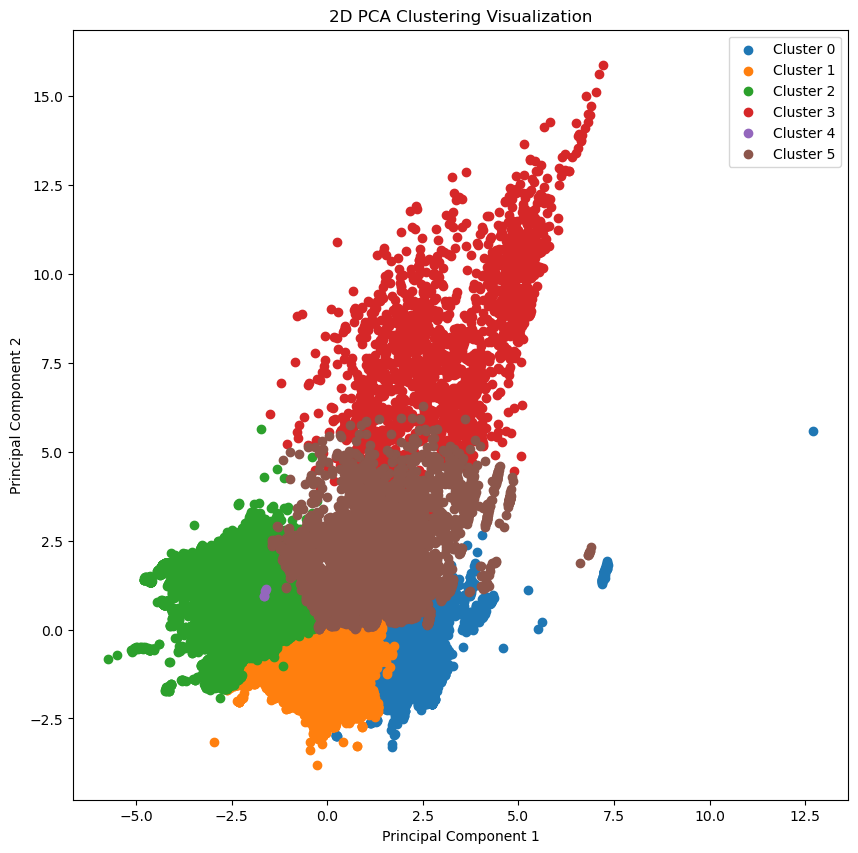

In [230]:

pca = PCA(n_components=2)  # Reduserer til to dimensjoner for visualisering
principal_components = pca.fit_transform(df_clustering_scaled)

# Legger til PCA-komponentene til en ny DataFrame for visualisering
df_visual = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])
df_visual["cluster"] = labels  # Legger til cluster-labels fra KMeans

# Plotter scatter plot med forskjellige farger for hvert cluster
plt.figure(figsize=(10, 10))
for i in range(k):
    cluster_subset = df_visual[df_visual['cluster'] == i]
    plt.scatter(cluster_subset['PC1'], cluster_subset['PC2'], label=f'Cluster {i}')

plt.title('2D PCA Clustering Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

**Results and comments**

TODO: "write a summary of your results, and discuss consequences of such results."
